## Introduction

---

**Task Overview:**

> Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world. The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. 

**Challenge:**

> In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

More information can be found [here](https://www.kaggle.com/c/bike-sharing-demand#description)

**Evaluation Metric**

- Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

In [1]:
# import libs
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'], infer_datetime_format=True)
test = pd.read_csv('test.csv', parse_dates=['datetime'], infer_datetime_format=True)

## Explore the Dataset

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [5]:
train.drop(['season', 'holiday', 'workingday', 'weather'], axis=1).describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- We have a skewed distribution for casual, registered and count.

### Thoughts

- How valid is the use of regression here? Our observations do not meet the independence assumption and therefore our errors will not be normally distributed?
    - Would another type of regression be more suitable? I'm not familiar with time series methods. 

## Missing Data

In [6]:
print "There are {} missing data in the training set".format(train.isnull().sum().sum())

There are 0 missing data in the training set


## Feature Extraction

In [7]:
# extract some features from the date

ind = pd.DatetimeIndex(train.datetime)

train['year'] = ind.year
train['month'] = ind.month
train['day'] = ind.day
train['dayofyear'] = ind.dayofyear
train['hour'] = ind.hour
train['dayofweek'] = ind.dayofweek
train['year_month'] = train.datetime.dt.date.apply(lambda x: str(x))
train['year_month'] = train.year_month.map(lambda x: x[:7])
train['year_month_day'] = train.datetime.dt.date.apply(lambda x: str(x))
train['year_month_day'] = train.year_month_day.map(lambda x: x[:10])

In [8]:
# create new feature for weekend
train.loc[:, 'weekend'] = np.where(train.dayofweek.isin([5,6]), 1, 0)

## Exploratory Data Analysis

## Variable Transformation

To avoid predicting negative counts, take log1p of registered, casual and count. This also helps make their distributions slightly more normal.

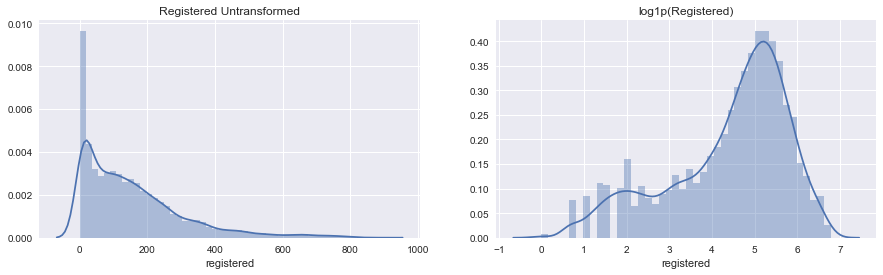

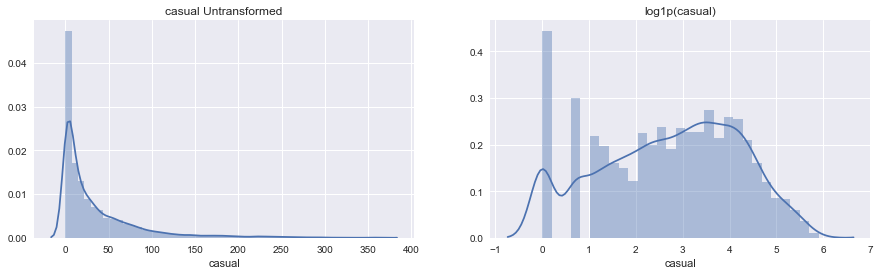

In [9]:
# registered users
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.distplot(train.registered, ax=ax[0])
sns.distplot(np.log1p(train.registered), ax=ax[1])
ax[0].set_title('Registered Untransformed')
ax[1].set_title('log1p(Registered)')

# casual users
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.distplot(train.casual, ax=ax[0])
sns.distplot(np.log1p(train.casual), ax=ax[1])
ax[0].set_title('casual Untransformed')
ax[1].set_title('log1p(casual)')

### Apply log1p transformation

In [10]:
train.loc[:, 'count'] = np.log1p(train.loc[:, 'count'])
train.loc[:, 'registered'] = np.log1p(train.loc[:, 'registered'])
train.loc[:, 'casual'] = np.log1p(train.loc[:, 'casual'])

### Initial Look at the Data

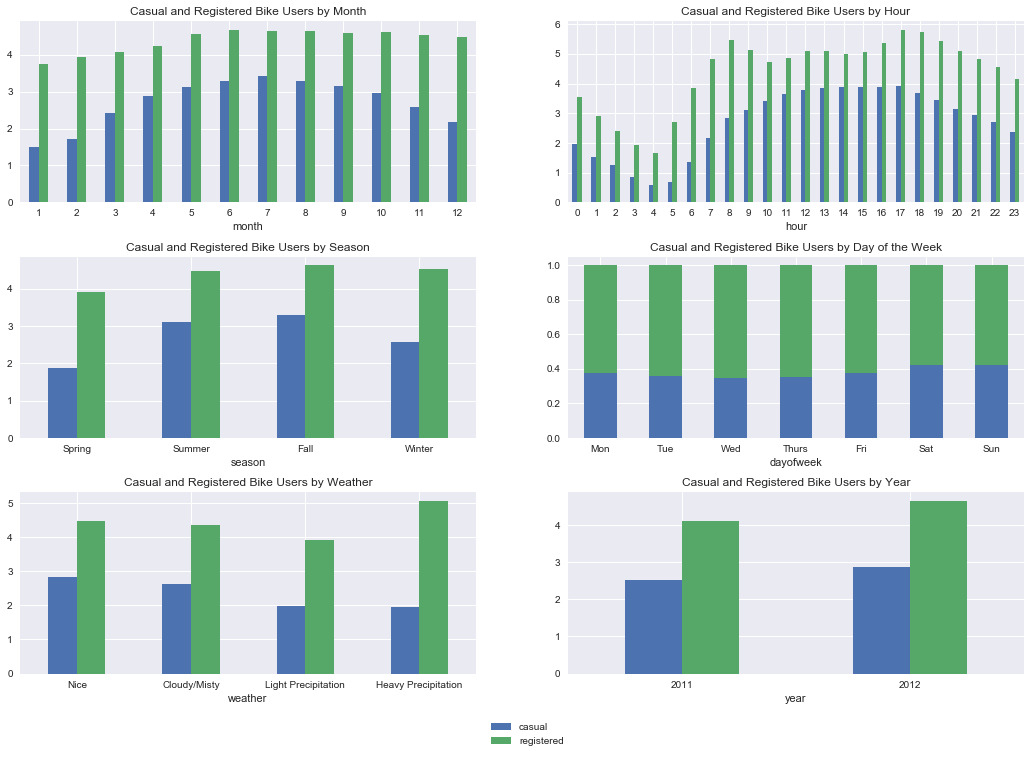

In [11]:
fig = plt.figure(figsize=(18,12))

# plot average registered and casual users by month
ax1 = plt.subplot2grid((3,2), (0,0))
train.pivot_table(index='month', values = ['registered', 'casual'], aggfunc=('mean')).plot(kind='bar', ax=ax1, rot=0, legend=False)
ax1.set_title('Casual and Registered Bike Users by Month')

# by hour
ax2 = plt.subplot2grid((3,2), (0,1))
train.pivot_table(index='hour', values = ['registered', 'casual'], aggfunc=('mean')).plot(kind='bar', ax=ax2, rot=0, legend=False)
ax2.set_title('Casual and Registered Bike Users by Hour')

# by season
ax3 = plt.subplot2grid((3,2), (1,0))
train.pivot_table(index='season', values = ['registered', 'casual'], aggfunc=('mean')).plot(kind='bar', ax=ax3, rot=0, legend=False)
ax3.set_title('Casual and Registered Bike Users by Season')
ax3.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter']);

# proportion of casual and registered users by day of the week
ax4 = plt.subplot2grid((3,2), (1,1))
pivot = train.pivot_table(index='dayofweek', values = ['registered', 'casual'], aggfunc=('mean'))
pivot = pivot.div(pivot.sum(axis=1), axis=0)
pivot.plot(kind='bar', ax=ax4, rot=0, stacked=True, legend=False)
ax4.set_title('Casual and Registered Bike Users by Day of the Week')
ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']);

# by season
ax5 = plt.subplot2grid((3,2), (2,0))
train.pivot_table(index='weather', values = ['registered', 'casual'], aggfunc=('mean')).plot(kind='bar', ax=ax5, rot=0, legend=False)
ax5.set_title('Casual and Registered Bike Users by Weather')
ax5.set_xticklabels(['Nice', 'Cloudy/Misty', 'Light Precipitation', 'Heavy Precipitation']);

# let's see how many people used the service in 2011 and 2012
ax6 = plt.subplot2grid((3,2), (2,1))
train.pivot_table(index='year', values = ['registered', 'casual'], aggfunc=('mean')).plot(kind='bar', ax=ax6, rot=0, legend=False)
ax6.set_title('Casual and Registered Bike Users by Year')

# set legend
ax5.legend(bbox_to_anchor=(1.2, -0.25), loc='best', borderaxespad=0.)

# adjust spacing
plt.subplots_adjust(hspace=0.3)

**Observations**

**Key Points**

- Casual and Registered users exhibit different behaviour.
    - It therefore makes sense to model each user type independently and combine both models for the final output.
- There is significant variation by month, hour and day of the week.
    - The relationship between registered and casual is not linear. Will therefore need to one-hot encode month, hour and day of the week.
- The weather has a predictable effect on the ridership, with fewer cycling in bad weather. The data showing the high number of riders renting bikes in heavy precipitation is an outlier.
- The scheme saw a rise in bike rentals by casual and registered users between 2011 and 2012.

**In more detail**

- By Month:
    - Casual and Registered bike rental numbers start slowly reaching a plateau in June. Casual users drop off from October to the end of the year, but registered users only experience a slight fall in bike rentals. Given that weather is likely at its worst in January and February, I am still suprised by the difference in the number of registered riders at the beginning and end of the year.
    - Could look at consolidating months 6-9 into one variable, as there is not a large difference in registered / casual in those months.
- By Hour:
    - Looking at the data by hour reveals a clear difference. Registered users (shown in green) follow a commuter pattern, with peaks centred on 8 o'clock in the morning and 5 o'clock in the evening and a smaller peak around lunchtime.
    - Casual users tend not to follow a commuter pattern, instead starting the day later and continuing throughout the afternoon.
    - This will be an interesting plot to factor by weekday.
        - We see a suprising numbers of users using the bicycles in the early hours of the morning as well as late evening. Perhaps this is weekend activity?
- By Season:
    - The data description describes the season's encoding as 
        - 1 = spring
        - 2 = summer
        - 3 = fall
        - 4 = winter 
    - Within this context, the results above are harder to understand. 
    - Examining the minimum and maximum dates for each season, it becomes clear that these seasons refer more to quarters. Here are the date ranges (mm-dd):
        - season 1 from 01-01 to 03-19
        - season 2 from 04-01 to 06-19
        - season 3 from 07-01 to 09-19
        - season 4 from 10-01 to 12-19
    - I don't think this variable will have a lot of predictive power.
- By Day of the Week
    - On average approximately 80% of the bikes rented are by registered users. During the week this is slightly higher, ranging between 84% and 87%. On the weekend however, the percentage of total bikes rented by casual users more than doubles, from approximately 13% to 30%.
- By Weather
    - In general, for both groups the worse the weather, the lower the number of riders. The number of riders in heavy precipitation is anomalous - heavy rain struck at 1800 on a Monday, perhaps catching a large number of commuters by suprise. 
    - This datapoint will be treated as an outlier and removed from the dataset.
- By Year
    - More and more users are using the bike service in Washington DC with  50% increase in the number of casual rides and a 69% increase in the number of registered users. 
    - Is this a linear increase? Did it jump up during the summer?
    
**Further Investigation**

I will explore the following in more detail:
- How does Bike Usage by Hour vary for working days and non-working days.
- How (At what point in time) did the increase(s) in ridership take place?
- Is there something that explains the discrepancy in riding numbers between December and January?

### The effect of the weather

Unexpectedly, the plot above showed a high number of rentals by registered users during heavy precipitation. As the table below, shows we only have one count of this. The observation will be dropped and treated as an outlier because it is not representative of how people behave in heavy precipitation - heavy rain does not cause people to jump on their bikes.

In [12]:
train.groupby('weather')[['registered', 'casual']].agg(['count'])

,registered,casual
,count,count
weather,,
1,7192,7192
2,2834,2834
3,859,859
4,1,1


Drop this observation

In [13]:
train.drop(train[train.weather == 4].index, axis=0, inplace=True)

** How does Bike Usage by Hour vary for working days and non-working days?**

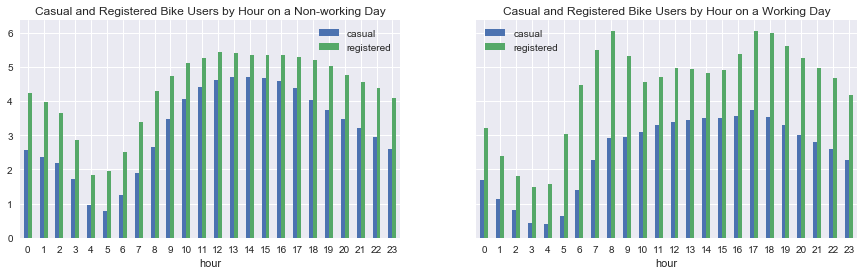

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharey=True)

train[train.workingday == 0].pivot_table(index='hour',
                                         values = ['registered', 'casual'], 
                                         aggfunc=('mean')).plot(kind='bar', ax=ax[0], rot=0)
ax[0].set_title('Casual and Registered Bike Users by Hour on a Non-working Day')

train[train.workingday == 1].pivot_table(index='hour',
                                         values = ['registered', 'casual'], 
                                         aggfunc=('mean')).plot(kind='bar', ax=ax[1], rot=0)
ax[1].set_title('Casual and Registered Bike Users by Hour on a Working Day')
# ax2.set_title('Casual and Registered Bike Users by Hour')

- On non-working days, registered and casual users have very similar usage patterns, predominantly using the bicycles during the afternoon. 
- On working days, there is a clear difference in the usage pattern of registered and casual users. A clear commuter pattern is observed for registered users, whereas the usage pattern for casual users is similar on working and non-working days with most bikes rented during the afternoon.
- **As mentioned above, given the different patterns observed for both populations, I will build individual models for casual and registered users**

The working day variable is likely to be an important variable in our model.

**At what point in time did the increase(s) in ridership take place?**

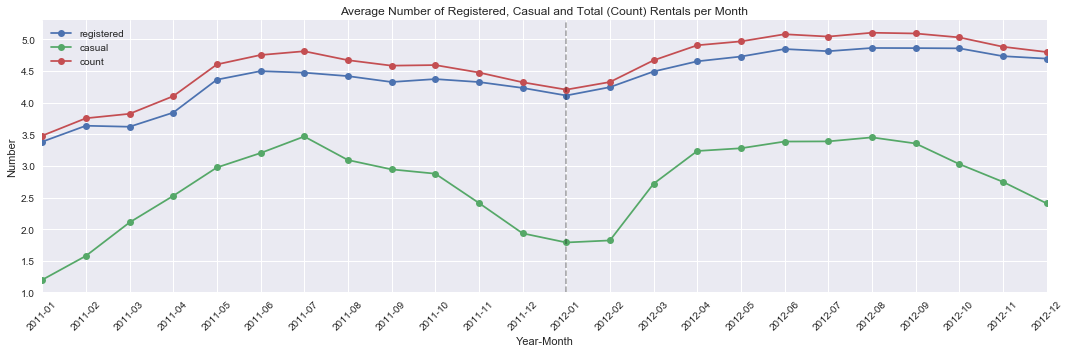

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18,5))

# plot average numbers by month
train.groupby('year_month')['registered'].mean().plot(kind='line', marker='o')
train.groupby('year_month')['casual'].mean().plot(kind='line', marker='o')
train.groupby('year_month')['count'].mean().plot(kind='line', rot=45, marker='o')

# edit plot
ax.xaxis.set_ticks(np.arange(len(train.year_month.unique())))
ax.set_xticklabels(train.year_month.unique())
plt.legend(loc='best')
plt.title('Average Number of Registered, Casual and Total (Count) Rentals per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number')

plt.axvline(x=12, color='k', linestyle='--', alpha=0.3)

- For registered users, the main growth period takes place during the first half of the year. The growth is monotonic.
- For casual users, the variation in the number of rental bikes is more cyclical with peaks in the summer and troughs in the winter.

### What about the temperature, humidity and windspeed?

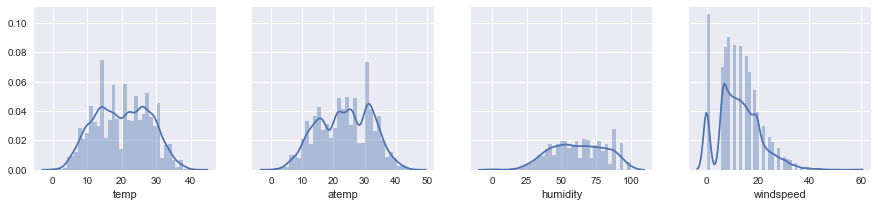

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(15,3), sharey=True)
for ax, f in zip(axes, ['temp', 'atemp', 'humidity', 'windspeed']):
    sns.distplot(train[f], ax=ax)

Histograms appear to be approximately normally distributed, apart from the high number of zeros for windspeed. These could be correct - let's investigate whether there's a pattern in those.

Let's look at scatterplots of each variable against registered and casual.

In [17]:
def scatter_function(target, color, subset_feature=None, subset_feature_value=None, suptitle=None):
    
    fig, axes = plt.subplots(1, 4, figsize=(15,3), sharey=True)

    if (subset_feature and subset_feature_value):
        subset = train[train[subset_feature] == subset_feature_value]
    else:
        subset = train
    
    for ax, f in zip(axes, ['temp', 'atemp', 'humidity', 'windspeed']):
        ax.scatter(subset[f], subset[target], color=color, alpha=.04)
        from scipy.stats import pearsonr

        r, p = pearsonr(subset[f], subset[target])
        
        title = "{} with Pearson's r = {:.2f}".format(f.title(), r)
        ax.set_title(title)
    
    fig.suptitle(suptitle)
    plt.subplots_adjust(top=0.8)
    

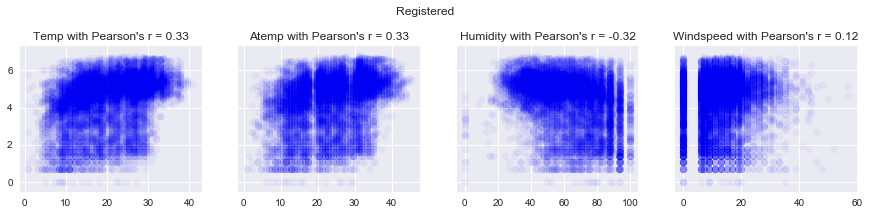

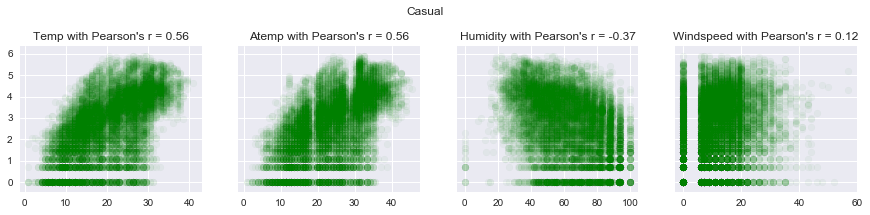

In [18]:
scatter_function('registered', 'b', suptitle='Registered')
scatter_function('casual', 'g', suptitle='Casual')

**Comments:**
    
- **Temp and Atemp:** 
    - Temp (temperature in Celsius) are Atemp ("feels like" temperature in Celsius) are highly correlated (r=0.98). Given the anomlaous drop in rider at around 30 degrees, I will focus on temp.
    - The effect of temperature is stronger on casual users than it is on registered users.
    - At lower temperatures, fewer registered and casual users rent bicycles. Registered users however get back on the bikes earlier than casual users, with high ridership numbers being observed at 5 degrees celsius and ridership numbers reaching their maximum at around 10 celsius. Casual users, on the other hand, stay away from the bikes during cold weather with few renting bikes at temperatures below 10 celsius and peak ridership happening once the temperature reaches 20 degrees. This may be caused by higher numbers using the bicycles in the summer and fall (70% of rides), when temperatures are higher.
- **Humidity:**
    - The relationship between humidity and the number of registered and casual rentals is weak and negative.
- **Windspeed:**
    - Very weak relationship. Perhaps this variable should be dichotomized (e.g. Windy if windspeed > 20 else Not Windy) or dropped.

Let's look at this for the working days and non-working days

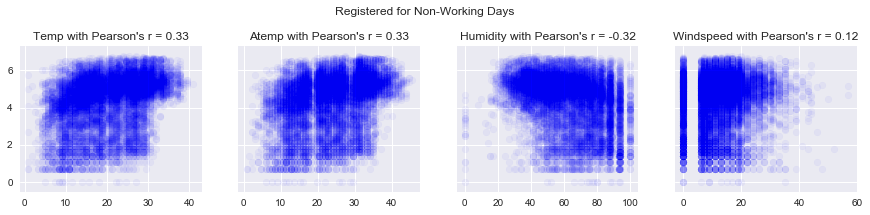

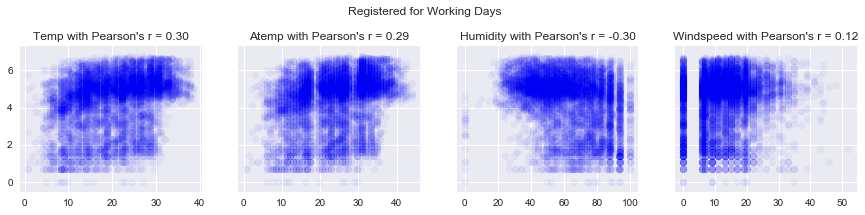

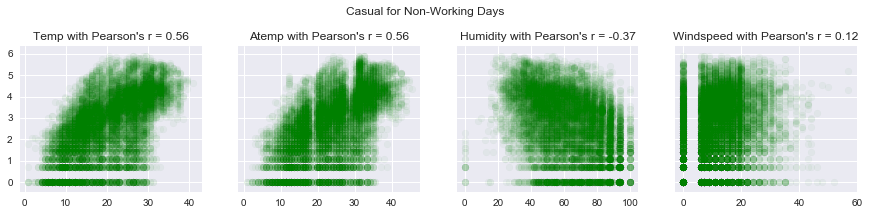

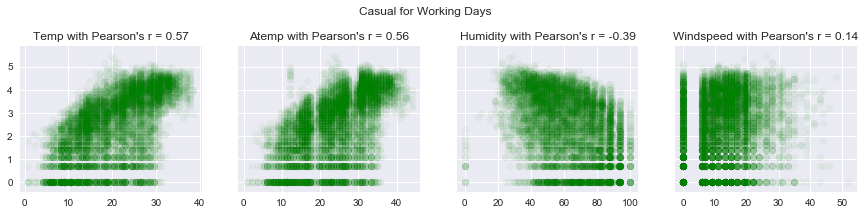

In [19]:
scatter_function('registered', 'b', 'workingday', 0, 'Registered for Non-Working Days')
scatter_function('registered', 'b', 'workingday', 1, 'Registered for Working Days')

scatter_function('casual', 'g', 'workingday', 0, 'Casual for Non-Working Days')
scatter_function('casual', 'g', 'workingday', 1, 'Casual for Working Days')

- For registered users, it being a working or non-working day doesn't change the effect of temperature, humidity and windspeed on rider numbers.
- For casual users, better weather leads to more cycling. This applies to non-working days (perhaps tourists and Washingtonians) as well as working days (Washingtoninans using the bike scheme to commute to work)

### Weather

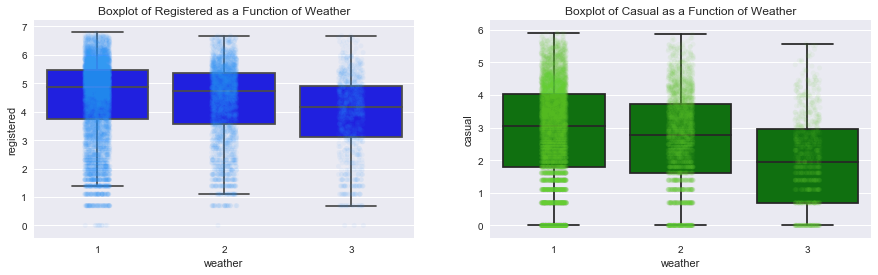

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.boxplot(x='weather', y='registered', data=train, showfliers=False, color='blue',  ax=ax[0])
sns.stripplot(x='weather', y='registered', data=train, jitter=True, alpha=.05, color='#3399FF',  ax=ax[0])

sns.boxplot(x='weather', y='casual', data=train, showfliers=False, color='green',  ax=ax[1])
sns.stripplot(x='weather', y='casual', data=train, jitter=True, alpha=.05, color='#66cc33',  ax=ax[1])

ax[0].set_title('Boxplot of Registered as a Function of Weather')
ax[1].set_title('Boxplot of Casual as a Function of Weather')

Given the non-linear relationship between weather and number of bike rentals, I will keep this variable categorical and not change it to a continuous variable.

In [21]:
# Other ideas to consider:

# Correlation Matrix
# corr = train.corr()
# plt.figure(figsize=(7,7))
# sns.heatmap(corr, vmax=.8, cbar=False)

# Outlier Detection
# def scatter_boxplot(feature, ax):
#     sns.boxplot(y=feature, data=train, orient='h', showfliers=False, ax=ax)
#     sns.stripplot(y=feature, data=train, jitter=True, size=2, alpha=.5,  orient='h', ax=ax)
#     title = feature.title()
#     ax.set_title(title)

# Let's plot boxplots for the appropriate variables to inspect for outliers.

# features = ['humidity',
#             'windspeed']

# fig, axes = plt.subplots(1, 2, figsize=(15,4))
# for ax, f in zip(axes, features):
#     scatter_boxplot(f, ax=ax)

# Comments
# Some outliers in Humidity and Windspeed
# Don't look into this until you've run the model and see if these features may be useful.
# Mind you, they may be once cleaned.

# Count, Registered and Casual have some outliers. But we know that these numbers can vary significantly by hour, month and day of the week. Let's facet our boxplots and determine if there are any outliers.

# g = sns.FacetGrid(train[train.year == 2012], col='month', col_wrap=4)
# g.map(sns.boxplot, 'dayofweek', 'registered',  color='b')

# histograms of count, registered are approximately normal within the hour
# g = sns.FacetGrid(train, col='hour', hue='workingday', size=3, col_wrap=4, aspect=1.5)
# g = g.map(plt.hist, 'registered', alpha=.5).add_legend()
# print "Histograms of the Number of Registered Hires by Hour"
# do the same for Casual Users

## Exploratory Data Analysis Summary

- Casual and Registered users exhibit different behaviour.
    - It therefore makes sense to model each user type independently and combine both models for the final output.
- There is significant variation by month, hour and day of the week.
- The weather has a predictable effect on the ridership, with fewer cycling in bad weather.
- The scheme saw a rise in bike rentals by casual and registered users between 2011 and 2012.
- Ridership patterns differ significantly on working and non-working days. Either this or day of the week should be included in our model.

### Approach

- Create a model in sklearn. but this doesn't offer many diagnostics or reports - it is more built for prediction, not inference.
- Create a model in statsmodels that gives you a little bit more fb.

Registered and casual do not have linear relationships with Hour and Month. So we'll one hot encode the data.

## Prepare Data for ML

One-hot encode the data

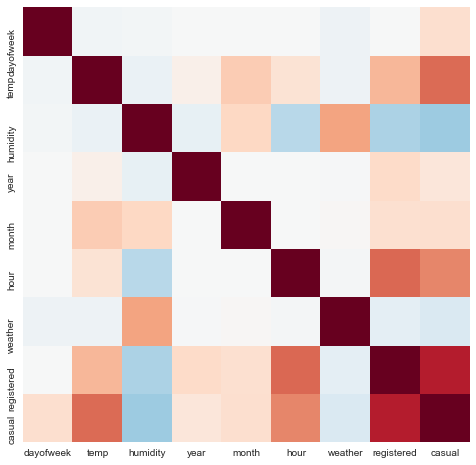

In [22]:
corr = train[['dayofweek', 'temp', 'humidity', 'year', 'month', 'hour', 'weather'] + ['registered', 'casual']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar=False)

- No significant multicollinearity observed. Can include all variables in statistical modelling.

In [23]:
all_columns = ['dayofweek', 'temp', 'humidity', 'year', 'month', 'hour', 'weather']
one_hot_columns = ['dayofweek', 'year', 'month', 'hour']
X = train[all_columns]
X = pd.get_dummies(X, columns = one_hot_columns)

y_reg = train['registered']
y_cas = train['casual']

### Define a RMSLE function to use as a scorer for the evaluation Metric

In [24]:
from sklearn.metrics import make_scorer

def rmsle(ypred, ytrue):
    "Function to compute Root Mean Squared Logarithmic Error"
    diff = ypred - ytrue
    squared_diff = np.square(diff)
    averaged_sum = np.mean(squared_diff)
    return np.sqrt(averaged_sum)

rmlse_scorer = make_scorer(rmsle, greater_is_better=False)

## Linear Regression Model

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# compute scores
scores_reg = cross_val_score(LinearRegression(), X, y_reg, cv = 10, scoring=rmlse_scorer)
scores_cas = cross_val_score(LinearRegression(), X, y_cas, cv = 10, scoring=rmlse_scorer)

# print out scores
print "RMSLE for Registered Users: {:.2f} (+/-) {:.2f}".format(scores_reg.mean(), scores_reg.std() * 2)
print "RMSLE for Casual Users: {:.2f} (+/-) {:.2f}".format(scores_cas.mean(), scores_cas.std() * 2)

RMSLE for Registered Users: -0.61 (+/-) 0.08
RMSLE for Casual Users: -0.65 (+/-) 0.12


### Train model

In [26]:
lm_reg = LinearRegression()
lm_reg.fit(X, y_reg)

lm_cas = LinearRegression()
lm_cas.fit(X, y_cas)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Predict on Test Set and Submit to Kaggle

In [27]:
# extract features for test dataset
ind = pd.DatetimeIndex(test.datetime)

test['year'] = ind.year
test['month'] = ind.month
test['hour'] = ind.hour
test['dayofweek'] = ind.dayofweek

In [28]:
X_test = test[all_columns]
X_test = pd.get_dummies(X_test, columns = one_hot_columns)

y_reg_pred = lm_reg.predict(X_test)
y_cas_pred = lm_cas.predict(X_test)

### Convert from logarithm into raw numbers and combine into final answer

In [29]:
# inverse of log1p
y_reg_pred = np.expm1(y_reg_pred)
y_cas_pred = np.expm1(y_cas_pred)

# combine
y_pred = y_reg_pred + y_cas_pred

In [30]:
output = pd.DataFrame({'datetime': test.datetime, 'count': y_pred})
output.to_csv('linear_reg_3.csv', index=False)

### Result

The linear model scored 0.64739 on the Kaggle Public Scoreboard. 

In [32]:
y_reg_train_pred = lm_reg.predict(X)
y_cas_train_pred = lm_cas.predict(X)

# careful how we combine
# first true count, then take logs afterwards.
y_train_pred = np.expm1(y_reg_train_pred) + np.expm1(y_cas_train_pred)
y_train_pred = np.log1p(y_train_pred)

print "The RMSLE score on the training set was {:.2f}".format(rmsle(y_train_pred, train['count']))
print "This is compared to 0.65 on the test set"

The RMSLE score on the training set was 0.57
This is compared to 0.65 on the test set


**Comments**

- The error on the training set is lower than the test set, as expected. It is not significantly lower, which could be an indication of overfitting.

Let's understand how each features contributes to the daily bicycle count. We'll do this separately for casual and registered users.

In [33]:
# registered users
params = pd.Series(lm_reg.coef_, X.columns)
params.head(15)

temp           2.138658e-02
humidity      -2.006644e-03
weather       -1.784709e-01
dayofweek_0    5.304761e+10
dayofweek_1    5.304761e+10
dayofweek_2    5.304761e+10
dayofweek_3    5.304761e+10
dayofweek_4    5.304761e+10
dayofweek_5    5.304761e+10
dayofweek_6    5.304761e+10
year_2011     -2.233760e+10
year_2012     -2.233760e+10
month_1       -9.870848e+10
month_2       -9.870848e+10
month_3       -9.870848e+10
dtype: float64

Don't understand why the coefficients are strange like this. Very large too. 

### Learning Curves

In [34]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y):

    plt.figure()
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y_reg, cv=10, scoring=rmlse_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.legend(loc='best')
    return plt

<module 'matplotlib.pyplot' from 'C:\Program Files\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

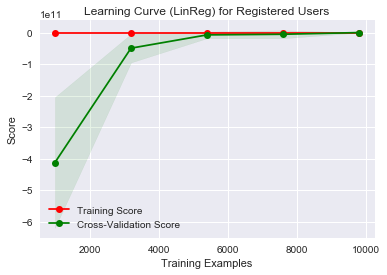

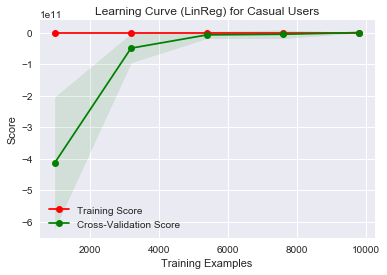

In [35]:
estimator = LinearRegression()
plot_learning_curve(estimator, 'Learning Curve (LinReg) for Registered Users', X, y_reg)
plot_learning_curve(estimator, 'Learning Curve (LinReg) for Casual Users', X, y_cas)

The scale for the axis is 1e11! Looking at the array of test scores we have some enormous errors. Unsure why that is.

In [36]:
# compute train and test scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y_cas, cv=10, scoring=rmlse_scorer)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

print (test_scores_mean)
print (train_scores_mean)

[ -8.64878537e+10  -2.94024330e+10  -2.41714931e+09  -2.66512708e+09
  -6.51192045e-01]
[-0.60256291 -0.64160487 -0.62672193 -0.62969123 -0.61871337]


The learning curve appear to meet at 6000 training samples. In fact, the scale is misleading (1e11 scaling!); the arrays above show that this convergence only happens at 10,000 samples. At 10,000 samples, we see that the test score is -0.65 whereas the train score is -0.62. To improve on this result, we need to include a more flexible (i.e. complex) model.

## Let's use some Subset Selection Techniques

The lasso model favours sparse solutions which I don't think will be applicable here - I think all features included will have some predictive power.

In [37]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score

params = {'alpha': [.1, 1, 10],
          'normalize': [True, False],
          'fit_intercept': [True, False]}

clf = GridSearchCV(estimator=Ridge(), param_grid=params, n_jobs=-1)

# compute scores
scores_reg = cross_val_score(clf, X, y_reg, cv = 10, scoring=rmlse_scorer)
scores_cas = cross_val_score(clf, X, y_cas, cv = 10, scoring=rmlse_scorer)

# print out scores
print "RMSLE for Registered Users using a Ridge Model: {:.2f} (+/-) {:.2f}".format(scores_reg.mean(), scores_reg.std() * 2)
print "RMSLE for Casual Users using a Ridge Model: {:.2f} (+/-) {:.2f}".format(scores_cas.mean(), scores_cas.std() * 2)

RMSLE for Registered Users using a Ridge Model: -0.61 (+/-) 0.08
RMSLE for Casual Users using a Ridge Model: -0.65 (+/-) 0.11


- No significant improvement demonstrated over a regular Linear Regression.

## We need a more flexible model. Let's try a Random Forest Regressor.

Takes a verrryyy long time to run.

In [38]:
# from sklearn.ensemble import RandomForestRegressor

# params = {'n_estimators': [100, 300, 500, 1000],
#           'max_depth': [5, 8, 15, 25],
#           'min_samples_split': [2, 5, 10],
#           'min_samples_leaf': [1, 2, 5, 10],
#           'max_features': ['log2', 'auto', 'sqrt']
#          }

# clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, n_jobs=-1)

# # compute scores
# scores_reg = cross_val_score(clf, X, y_reg, cv = 10, scoring=rmlse_scorer)
# scores_cas = cross_val_score(clf, X, y_cas, cv = 10, scoring=rmlse_scorer)

# # print out scores
# print "RMSLE for Registered Users: {:.2f} (+/-) {:.2f}".format(scores_reg.mean(), scores_reg.std() * 2)
# print "RMSLE for Casual Users: {:.2f} (+/-) {:.2f}".format(scores_cas.mean(), scores_cas.std() * 2)

In [39]:
# y = train['count']
# scores_all = cross_val_score(RandomForestRegressor(), X, y, cv = 10, scoring=rmlse_scorer)

## Random Forest Regressor

Get an idea of the accuracy possible.

In [42]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()

# compute scores
scores_reg = cross_val_score(estimator, X, y_reg, cv = 10, scoring=rmlse_scorer)
scores_cas = cross_val_score(estimator, X, y_cas, cv = 10, scoring=rmlse_scorer)

# print out scores
print "RMSLE for Registered Users using a Ridge Model: {:.2f} (+/-) {:.2f}".format(scores_reg.mean(), scores_reg.std() * 2)
print "RMSLE for Casual Users using a Ridge Model: {:.2f} (+/-) {:.2f}".format(scores_cas.mean(), scores_cas.std() * 2)

RMSLE for Registered Users using a Ridge Model: -0.49 (+/-) 0.30
RMSLE for Casual Users using a Ridge Model: -0.66 (+/-) 0.22


### Predict on test set and submit to Kaggle

In [48]:
# train
tree_reg = RandomForestRegressor()
tree_reg.fit(X, y_reg)

tree_cas = RandomForestRegressor()
tree_cas.fit(X, y_cas)

# predict
y_tree_reg_pred = tree_reg.predict(X_test)
y_tree_cas_pred = tree_cas.predict(X_test)

# inverse of log1p
y_tree_reg_pred = np.expm1(y_tree_reg_pred)
y_tree_cas_pred = np.expm1(y_tree_cas_pred)

# combine to give count score
y_tree_pred = y_tree_reg_pred + y_tree_cas_pred

# output to file for testing
output = pd.DataFrame({'datetime': test.datetime, 'count': y_tree_pred})
output.to_csv('random_forest.csv', index=False)


Now scoring 0.47821 on the Kaggle Public Scoreboard.

### What would I score if I passed in all variables to the Random Forest Regressor?

In [59]:
all_columns = ['dayofweek', 'temp', 'humidity', 'year', 'month', 'hour',
               'weather', 'season', 'holiday', 'workingday', 'windspeed']
one_hot_columns = ['dayofweek', 'year', 'month', 'hour', 'season']

X = train[all_columns]
X = pd.get_dummies(X, columns = one_hot_columns)

In [60]:
estimator = RandomForestRegressor()

# compute scores
scores_reg = cross_val_score(estimator, X, y_reg, cv = 10, scoring=rmlse_scorer)
scores_cas = cross_val_score(estimator, X, y_cas, cv = 10, scoring=rmlse_scorer)

# print out scores
print "RMSLE for Registered Users using a Ridge Model: {:.2f} (+/-) {:.2f}".format(scores_reg.mean(), scores_reg.std() * 2)
print "RMSLE for Casual Users using a Ridge Model: {:.2f} (+/-) {:.2f}".format(scores_cas.mean(), scores_cas.std() * 2)

RMSLE for Registered Users using a Ridge Model: -0.43 (+/-) 0.23
RMSLE for Casual Users using a Ridge Model: -0.64 (+/-) 0.23


### Predict on test set and submit to Kaggle

In [61]:
X_test = test[all_columns]
X_test = pd.get_dummies(X_test, columns = one_hot_columns)

In [62]:
# train
tree_reg = RandomForestRegressor()
tree_reg.fit(X, y_reg)

tree_cas = RandomForestRegressor()
tree_cas.fit(X, y_cas)

# predict
y_tree_reg_pred = tree_reg.predict(X_test)
y_tree_cas_pred = tree_cas.predict(X_test)

# inverse of log1p
y_tree_reg_pred = np.expm1(y_tree_reg_pred)
y_tree_cas_pred = np.expm1(y_tree_cas_pred)

# combine to give count score
y_tree_pred = y_tree_reg_pred + y_tree_cas_pred

# output to file for testing
output = pd.DataFrame({'datetime': test.datetime, 'count': y_tree_pred})
output.to_csv('random_forest_2.csv', index=False)


0.41574 scored on Kaggle Public Leaderboard, placing me at position 390 ish out of 3251.